# Emotion Analysis - Part 1
### <i>Data Preparation and Emotion Analysis with Text-Classification Model</i>

[Imports]

In [13]:
### Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
from pandas.core.dtypes.common import infer_dtype_from_object
from datetime import datetime, timedelta

from plotly import hist_frame

style.use('ggplot')
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import json
import torch
from transformers import pipeline
from tqdm import tqdm
import pytz

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aklei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
RUN_TYPE = 0 # set to 1 to repeat file creation process

[Data Preparation]<br>
Normalizing the quoted_tweets-dictionary to create a dataframe that contains the text of the quoted and origional tweet

In [15]:
### Prepare dataframe for analysis
# Import dataset
df_tweets = pd.read_csv(
    '../data/twitter/tweets_isTweet.csv',
    dtype={'id': 'object'},
    low_memory=False
)
# Parameter for weighing emotions per event later in Event Study
df_tweets['total_engagement'] = (df_tweets['retweetCount'] +
                                 df_tweets['likeCount'] +
                                 df_tweets['replyCount'] +
                                 df_tweets['quoteCount'] +
                                 df_tweets['viewCount'])
df_tweets = df_tweets[['id', 'createdAt', 'text', 'quoted_tweet', 'total_engagement']]
df_tweets = df_tweets.rename(columns={'id': 'tweet_id', 'text': 'tweet_text'})

# Normalize json column
quoted_tweets_normalized = pd.json_normalize(
    df_tweets['quoted_tweet'].apply(
        lambda x: json.loads(x) if pd.notna(x) and isinstance(x, str) else None
    )
)
quoted_tweets_normalized = quoted_tweets_normalized.rename(columns={
    'id': 'quoted_tweet_id',
    'text': 'quoted_tweet_text'
})

# Link by index
df_tweets.index = quoted_tweets_normalized.index

# Concat both dataframes
df_tweets_normalized = pd.concat([
    df_tweets[['tweet_id', 'createdAt', 'tweet_text', 'total_engagement']],
    quoted_tweets_normalized[['quoted_tweet_id', 'quoted_tweet_text']]
], axis=1)

# View data
print(df_tweets.columns)
df_tweets_normalized.head()

Index(['tweet_id', 'createdAt', 'tweet_text', 'quoted_tweet',
       'total_engagement'],
      dtype='object')


,tweet_id,createdAt,tweet_text,total_engagement,quoted_tweet_id,quoted_tweet_text
0,1917726279195058338,Wed Apr 30 23:42:29 +0000 2025,https://t.co/U6tI9pdin6,30834704,NaN,NaN
1,1917693698281787564,Wed Apr 30 21:33:01 +0000 2025,https://t.co/1c1WjFpOva,56245268,NaN,NaN
2,1917225430702240067,Tue Apr 29 14:32:17 +0000 2025,This is a big deal,63373125,1917223651625099407,"Last week, Treasury went live with its first a..."
3,1917114631287718009,Tue Apr 29 07:12:01 +0000 2025,https://t.co/6xSd8l67FN,17687048,NaN,NaN
4,1917103264417649121,Tue Apr 29 06:26:50 +0000 2025,Whoa,29853429,1917011279757066291,🚨THE INVISIBLE PUPPET MASTERS: AI'S DISTURBING...


[Data Transformation]<br>
The following cell contains functions for the second step of data preparation, namely removing noise, truncating text, stemming words, and subsequently performing the emotion analysis.

In [16]:
### Pre-process data for the analysis
## Variables
ekman_emotions = ['anger', 'fear', 'joy', 'sadness', 'disgust', 'surprise']

## Classifier
# Load Hugging Face's emotion classifier
print("[Info]")
device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion", top_k=None, device=0 if device == "cuda" else -1)

## Functions
# Removing noise from the text
def remove_noise(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+httpss\S+", '', text, flags=re.MULTILINE) # Remove Url
    text = re.sub(r"\@w+|\#", '', text) # remove @ and #
    text = re.sub(r"[^\w\s]", '', text) # remove punctuation
    text_tokens = text.split()
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

# Reduction of dimensionality by abstracting word to word stem
stemmer = PorterStemmer()
def stem_words(text):
    words = text.split()
    stemmed_text = [stemmer.stem(word) for word in words]
    return stemmed_text

def truncate_text(text, max_length=512):
    words = text.split()
    return " ".join(words[:max_length])

def compute_emotions(text):
    if not isinstance(text, str) or text.strip() == "":
        print("[ComputeEmotions] Empty cell after data cleaning. Returning 0.0 for all emotions.")
        return {emotion: 0.0 for emotion in ekman_emotions}

    try:
        # Classify emotions using the Hugging Face pipeline and handle errors
        results = classifier(text)[0]
        if not results or not isinstance(results, list) or len(results[0]) == 0:
            return {emotion: 0.0 for emotion in ekman_emotions}

        emotion_scores = {result['label']: result['score'] for result in results}
        return {emotion: emotion_scores.get(emotion, 0.0) for emotion in ekman_emotions}

    except Exception as e:
        print(f"[ComputeEmotions] Error while processing text: {text[:20]}... Error: {e}")
        return {emotion: 0.0 for emotion in ekman_emotions}


def append_emotions(df: pd.DataFrame, text_column: str) -> pd.DataFrame:
    if text_column not in df.columns:
        raise ValueError(f"[AppendEmotions] Column '{text_column}' not found in DataFrame.")
    
    print("[AppendEmotions] Computing emotions for column:", text_column)

    cleaned_column = f"{text_column}_cleaned"
    df[cleaned_column] = df[text_column].apply(
        lambda x: " ".join(stem_words(remove_noise(x))) if isinstance(x, str) and x.strip() else ""
    )

    # Truncate text if cleaned text exceeds 512 tokens
    if (df[cleaned_column].str.split().str.len() > 512).any():
        print("[AppendEmotions] At least one row with more than 512 tokens - truncating text ...")
        df[cleaned_column] = df[cleaned_column].apply(lambda x: truncate_text(x, max_length=512))

    emotion_scores = [compute_emotions(text) for text in tqdm(df[cleaned_column], desc="[AppendEmotions] Processing emotions")]
    emotions_df = pd.DataFrame(emotion_scores)
    emotions_df.index = df.index
    emotions_df.columns = [f"{text_column}_{emotion}" for emotion in ekman_emotions]
    
    # Add dominant emotion column
    dominant = emotions_df.idxmax(axis=1).apply(lambda x: x.split('_')[-1])
    all_zero = emotions_df.eq(0.0).all(axis=1)
    dominant[all_zero] = np.nan
    emotions_df[f"{text_column}_dominant_emotion"] = dominant

    # Insert right hand of input text_column
    insert_at = df.columns.get_loc(text_column) + 1

    # DataFrame in drei Teile splitten und zusammenfügen
    left = df.iloc[:, :insert_at]
    right = df.iloc[:, insert_at:].drop(columns=[cleaned_column], errors='ignore')
    result_df = pd.concat([left, df[[cleaned_column]], emotions_df, right], axis=1)

    return result_df

[Info]


Device set to use cpu


[Applying Functions]<br>
This part is only run once to create the new csv-file. Subsequently, the further analysis is performed on the new dataset.

In [17]:
# Perform emotion analysis for columns specified
if RUN_TYPE == 1:
    for col in ['tweet_text']:#, 'quoted_tweet_text']:
        df_tweets_normalized = append_emotions(df_tweets_normalized, text_column=col)

    # Safe the DataFrame with emotions to csv
    df_tweets_normalized.to_csv('../data/twitter/tweets_isTweet_emotions.csv', index=False)

# Emotion Analysis - Part 2
### <i>Formatting & Data Exploration</i>

In [18]:
# Formatting
## Set timezone
eastern = pytz.timezone("US/Eastern")

## Read necessary data and convert to the same timezone
### Tweet data
df_tweets_normalized = pd.read_csv('../data/twitter/tweets_isTweet_emotions.csv')[
    ['tweet_id',
     'createdAt',
     'total_engagement',
     'tweet_text_anger',
     'tweet_text_fear',
     'tweet_text_joy',
     'tweet_text_sadness',
     'tweet_text_disgust',
     'tweet_text_surprise',
     'tweet_text_dominant_emotion'
    ]
].dropna()
df_tweets_normalized = df_tweets_normalized.rename(columns={
    'createdAt': 'timestamp',
    'tweet_text_anger': 'anger',
    'tweet_text_fear': 'fear',
    'tweet_text_joy': 'joy',
    'tweet_text_sadness': 'sadness',
    'tweet_text_disgust': 'disgust',
    'tweet_text_surprise': 'surprise',
    'tweet_text_dominant_emotion': 'tweet_emotion'})
df_tweets_normalized['timestamp'] = pd.to_datetime(
    df_tweets_normalized['timestamp'],
    format="%a %b %d %H:%M:%S %z %Y",
    errors="coerce")
df_tweets_normalized['timestamp'] = df_tweets_normalized['timestamp'].dt.tz_convert(eastern)

### Stock data
df_stock_data = pd.read_csv('../data/stocks/tsla_intraday_202305_202504-1m.csv')
df_stock_data = df_stock_data.rename(columns={'Unnamed: 0': 'timestamp'})
df_stock_data['timestamp'] = pd.to_datetime(df_stock_data['timestamp']).dt.tz_localize(eastern)
df_stock_data['log_return'] = np.log(df_stock_data['close'] / df_stock_data['close'].shift(1))

df_tweets_normalized.head()

,tweet_id,timestamp,total_engagement,anger,fear,joy,sadness,disgust,surprise,tweet_emotion
2,1917225430702240067,2025-04-29 10:32:17-04:00,63373125,0.057449,0.005243,0.915674,0.014150,0.0,0.002263,joy
4,1917103264417649121,2025-04-29 02:26:50-04:00,29853429,0.073187,0.316359,0.514874,0.004891,0.0,0.081774,joy
5,1917099777327829386,2025-04-29 02:12:59-04:00,35723205,0.030421,0.004519,0.955584,0.004746,0.0,0.003318,joy
6,1917071819003334728,2025-04-29 00:21:53-04:00,36921036,0.324097,0.072620,0.478726,0.112020,0.0,0.006192,joy
7,1917048786633036129,2025-04-28 22:50:22-04:00,71810230,0.861536,0.128874,0.003186,0.002088,0.0,0.002448,anger


<Axes: xlabel='tweet_emotion', ylabel='count'>

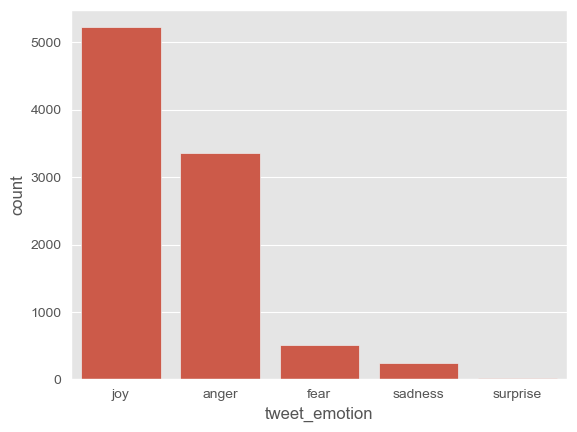

In [19]:
# Data exploration
## Emotion Occurrence
sns.countplot(x='tweet_emotion', data=df_tweets_normalized)

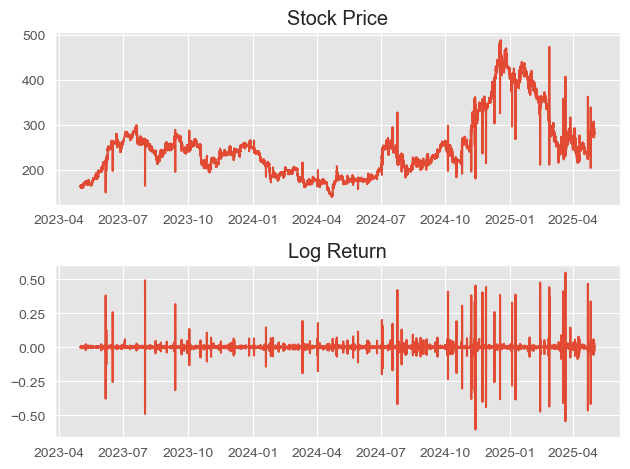

In [20]:
## Timeseries Data
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(df_stock_data['timestamp'], df_stock_data['close'])
ax1.set_title('Stock Price')

ax2.plot(df_stock_data['timestamp'], df_stock_data['log_return'])
ax2.set_title('Log Return')

plt.tight_layout()
plt.show()

[Event Study]<br>
1. Data Preparation

In [21]:
# 1. Filter out tweets outside market hours (2h)
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time >= pd.to_datetime("04:00").time()
]
df_tweets_normalized = df_tweets_normalized[
    df_tweets_normalized['timestamp'].dt.time <= pd.to_datetime("17:59").time()
]

# 2. Sort by time
df_tweets_normalized = df_tweets_normalized.sort_values("timestamp").reset_index(drop=True)

# 3. Compute time difference between tweets
df_tweets_normalized['time_diff'] = df_tweets_normalized['timestamp'].diff()

# 4. Cluster Tweets to events with time_diff >= 7h
df_tweets_normalized['new_event'] = df_tweets_normalized['time_diff'] > pd.Timedelta(hours=7)

# 5. Cumulate events in event_id
df_tweets_normalized['event_id'] = df_tweets_normalized['new_event'].cumsum()

# 6. Compute dominant emotion per event event_emotion



df_tweets_normalized.head()

,tweet_id,timestamp,total_engagement,anger,fear,joy,sadness,disgust,surprise,tweet_emotion,time_diff,new_event,event_id
0,1653075645138710528,2023-05-01 12:35:21-04:00,11729439,0.426503,0.006520,0.508242,0.026972,0.0,0.007145,joy,NaT,False,0
1,1653420591607607297,2023-05-02 11:26:02-04:00,15003485,0.338571,0.199239,0.331740,0.103573,0.0,0.012653,anger,0 days 22:50:41,True,1
2,1653447855401468011,2023-05-02 13:14:22-04:00,23966402,0.005906,0.001910,0.984496,0.005662,0.0,0.000927,joy,0 days 01:48:20,False,1
3,1654183141605625860,2023-05-04 13:56:08-04:00,47365060,0.374810,0.456166,0.110602,0.046511,0.0,0.006523,fear,2 days 00:41:46,True,2
4,1654235943514013697,2023-05-04 17:25:57-04:00,12640348,0.181239,0.100499,0.662629,0.041277,0.0,0.010604,joy,0 days 03:29:49,False,2
